# Imports librairies & données

## Librairies

In [1]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from matplotlib import colormaps 
import pandas as pd
from medpy.filter.smoothing import anisotropic_diffusion
from tqdm import tqdm
import os
import napari
from skimage import io
from skimage.util import crop
import extract
from shapely import convex_hull
from shapely import MultiPoint

C:\App\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


## Image de base

In [178]:
image = io.imread("../data/rhizophagus/06/3/R06_30_06_P12.jpg")

In [179]:
img = image[:, :, 1]

## Graphe G

In [180]:
G = pickle.load(open("../data/rhizophagus/06/3/R06_30_06_P12.pkl", "rb")) # .pkl réseau raw, .pklclean 

In [181]:
pts = {n : G.nodes[n]["pts"][0] for n in G.nodes } # [0] si .pkl 
pts = {n : (y, -x) for n, (x, y) in pts.items()} 

## Thème

In [2]:
sns.set_theme(style="whitegrid", context="notebook", palette="pastel")

# Fonctions à définir

## Preprocessing

In [3]:
def simple_graph(G):
    """
    Simplifies a graph by contracting paths of degree-2 nodes into single edges.
    The new edge's weight is the sum of the weights of the replaced edges.
 
    Parameters:
    G (networkx.Graph): Input graph with edge weights stored as "weight" attributes.
 
    Returns:
    networkx.Graph: Simplified graph.
    """
    # Identify nodes with degree ≠ 2
    main_nodes = {n for n in G.nodes if G.degree[n] != 2}
 
    # Subgraph of degree-2 nodes
    deg2_subgraph = G.subgraph(set(G.nodes) - main_nodes)
 
    # Find connected components of the degree-2 subgraph
    components = list(nx.connected_components(deg2_subgraph))
 
    # Create new edges connecting the endpoints of each component, summing their weights
    new_edges = []
    for component in components:
        component = set(component)  # Convert to set for fast lookup
        endpoints = set()
        total_weight = 0
 
        # Track visited edges to avoid double counting
        visited_edges = set()
 
        for node in component:
            for neighbor in G.neighbors(node):
                edge = tuple(sorted((node, neighbor)))  # Avoid direction issues
                if edge not in visited_edges:
                    weight = G[node][neighbor].get("weight", 1)  # Default weight = 1 if missing
                    total_weight += weight  # Sum each edge only once
                    visited_edges.add(edge)
 
                if neighbor not in component:
                    endpoints.add(neighbor)
 
        # Keep only neighbors that are not in the component (endpoints)
        endpoints = list(endpoints)
        if len(endpoints) == 2:  # Valid edge case
            new_edges.append((endpoints[0], endpoints[1], total_weight))
 
    # Construct the simplified graph
    H = G.copy()
    H.remove_nodes_from(deg2_subgraph.nodes)
    H.add_edges_from((u, v, {"weight": w}) for u, v, w in new_edges)
 
    return H

## Mesures de base

### Distribution des degrés

In [4]:
def fct_degrees(G) :
    degrees = G.degree()
    degrees = [val for (node, val) in G.degree()]
    d1 = np.array(degrees)
    return d1

### Densité de cycles

In [5]:
def cycle_density(G):
    """
    Calculates the cycle density: number of independent cycles divided
    by the number of nodes or edges.
 
    Parameters
    ----------
    G : networkx.Graph
        The graph with node positions stored as the "pos" attribute.
 
    Returns
    -------
    float
        Cycle density
    """
    num_cycles = len(list(nx.cycle_basis(G)))
    num_nodes = G.number_of_nodes()
    return num_cycles / num_nodes

In [6]:
def num_cycles(G):
    num_cycles = len(list(nx.cycle_basis(G)))
    return num_cycles

### Densité spatiale

In [7]:
def spatial_density(G) :
    hyphal_length = total_hyphal_length(G)
    node_positions = {n : G.nodes[n]["pts"] for n in G.nodes } # ajouter [0] si liste de listes 
    node_positions = [tuple(pts) for pts in node_positions.values()]
    area = convex_hull(MultiPoint(node_positions)).area
    spatial_density = hyphal_length/area
    return spatial_density

### Longueur hyphale

In [8]:
def total_hyphal_length(G, weight="weight"):
    """Compute the total hyphal length in the network.
 
    If edges have a 'length' attribute, sum those. Otherwise, compute Euclidean distance.
    """
    total_length = 0.0
 
    for u, v, data in G.edges(data=True):
        if weight in data:
            total_length += data[weight]
        elif "pts" in G.nodes[u] and "pts" in G.nodes[v]:
            pos_u = np.array(G.nodes[u]["pts"])
            pos_v = np.array(G.nodes[v]["pts"])
            total_length += np.linalg.norm(pos_u - pos_v)
        else:
            raise ValueError("Edge length missing and node positions unavailable.")
 
    return total_length

### Longueurs des liens

In [9]:
def distance(G, node1, node2):
    """Helper function to calculate distance between two nodes"""
    return np.linalg.norm(
        np.array(G.nodes[node1]["pts"]) - np.array(G.nodes[node2]["pts"])
    )

In [10]:
def edges_lengths(G) :
    e_l = {}
    for u, v in G.edges():
        dist = distance(G, u, v)
        e_l[(u, v)] = dist
    return e_l

## Mesures d'efficience et robustesse

### Efficience globale

In [11]:
def global_efficiency_weighted(G, weight="weight"):

    """

    compute the global efficiency of a weighted graph.
 
    Parameters

    ----------

    G : networkx.Graph

        graph where edges may have weights representing distances or costs.

    weight : str, optional

        name of the edge attribute to use as weight (default is "weight").
 
    Returns

    -------

    g_eff : float

        global efficiency of the graph, defined as the average of the 

        inverse shortest path lengths between all pairs of nodes.

    """
 
    # adapted from networkx to take weights into account
 
    N = len(G)

    n_paths = N * (N - 1)  # total number of ordered node pairs
 
    if N > 5000:

        print("too large:", G)

        return np.nan, np.nan
 
    if n_paths == 0 :

        return 0, 0
 
    node_pos = {n : np.array(G.nodes[n]["pts"]) for n in G.nodes}
 
    g_eff = 0

    average_length = 0

    g_eff_euclid = 0
 
    lengths = nx.all_pairs_dijkstra_path_length(G, weight=weight, backend="parallel")  # compute shortest paths

    for source, targets in lengths:

        for target, length_sp in targets.items():

            if length_sp > 0:  # avoid self-loops

                g_eff += 1 / length_sp

                average_length += length_sp 
 
                length_euclid = np.linalg.norm(node_pos[target] - node_pos[source])

                g_eff_euclid += 1 / length_euclid
 
    g_eff /= n_paths

    g_eff_euclid /= n_paths

    average_length /= n_paths
 
    return g_eff if g_eff==0 else g_eff / g_eff_euclid, average_length

In [47]:
def global_efficiency_weighted_tips(G, weight="weight"):

    """

    compute the global efficiency of a weighted graph.
 
    Parameters

    ----------

    G : networkx.Graph

        graph where edges may have weights representing distances or costs.

    weight : str, optional

        name of the edge attribute to use as weight (default is "weight").
 
    Returns

    -------

    g_eff : float

        global efficiency of the graph, defined as the average of the 

        inverse shortest path lengths between all pairs of nodes.

    """
 
    # adapted from networkx to take weights into account
 
    N = len(G)

    n_paths = N * (N - 1)  # total number of ordered node pairs
 
    # if N > 5000:

    #     print("too large:", G)

    #     return np.nan, np.nan
 
    if n_paths == 0 :

        return 0, 0
 
    node_pos = {n : np.array(G.nodes[n]["pts"]) for n in G.nodes}

    sources = [n for n, d in G.degree() if d == 1]
 
    g_eff = 0

    average_length = 0

    g_eff_euclid = 0
 
    # lengths = nx.all_pairs_dijkstra_path_length(G, weight=weight, backend="parallel")  # compute shortest paths

    lengths = []

    for source in sources:

        dict = nx.single_source_dijkstra_path_length(G, source, weight="weight")
    
        lengths.append((source, dict))
    
    # lengths = {}

    # for source in sources:
    #     lengths[source] = nx.single_source_dijkstra_path_length(G, source, weight="weight")
    
    for source, targets in lengths:

        for target, length_sp in targets.items():

            if length_sp > 0:  # avoid self-loops

                g_eff += 1 / length_sp

                average_length += length_sp 
 
                length_euclid = np.linalg.norm(node_pos[target] - node_pos[source])

                g_eff_euclid += 1 / length_euclid
 
    g_eff /= n_paths

    g_eff_euclid /= n_paths

    average_length /= n_paths
 
    return g_eff if g_eff==0 else g_eff / g_eff_euclid, average_length

### Efficience locale

In [12]:
def local_efficiency_weighted(G):

    """Returns the average local efficiency of the graph.
 
    The *efficiency* of a pair of nodes in a graph is the multiplicative

    inverse of the shortest path distance between the nodes. The *local

    efficiency* of a node in the graph is the average global efficiency of the

    subgraph induced by the neighbors of the node. The *average local

    efficiency* is the average of the local efficiencies of each node [1]_.
 
    Parameters

    ----------

    G : :class:`networkx.Graph`

        An undirected graph for which to compute the average local efficiency.
 
    Returns

    -------

    float

        The average local efficiency of the graph.
 
    Examples

    --------
>>> G = nx.Graph([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3)])
>>> nx.local_efficiency(G)

    0.9166666666666667
 
    Notes

    -----

    Edge weights are ignored when computing the shortest path distances.
 
    See also

    --------

    global_efficiency
 
    References

    ----------

    .. [1] Latora, Vito, and Massimo Marchiori.

           "Efficient behavior of small-world networks."

           *Physical Review Letters* 87.19 (2001): 198701.
<https://doi.org/10.1103/PhysRevLett.87.198701>
 
    """

    N = len(G)

    efficiency = (global_efficiency_weighted(G.subgraph(G[v])) for v in G)

    efficiency_list, _ = zip(*efficiency)

    return sum(efficiency_list) / N

### Robustesse

In [5]:
def robustness_curve(G, root_node=0, n_steps=20, mode="uniform", seed=None, n_reps=10, max_fraction_rm=1):

    """

    Compute robustness curve: percentage of total network length

    connected to root node as a function of fraction of edge length removed.

    Averaged over multiple repetitions.
 
    Parameters:

        G : networkx.Graph

            The input graph with edge attribute 'weight'.

        root_node : node label

            The node considered as the root.

        n_steps : int

            Number of removal steps between 0 and 1.

        mode : str

            'uniform' (default) or 'length_weighted' for removal probability.

        seed : int or None

            Random seed for reproducibility.

        n_reps : int

            Number of repetitions to average over.
 
    Returns:

        fractions_removed : np.ndarray

        fractions_connected_mean : np.ndarray

    """
 
    rng = np.random.seed(seed)
 
    edges = list(G.edges(data=True))

    weights = np.array([attr['weight'] for (_, _, attr) in edges])

    total_length = weights.sum()
 
    fractions_removed = np.linspace(0, max_fraction_rm, n_steps)

    all_fractions_connected = []
 
    for _ in range(n_reps):

        fractions_connected = []
 
        for fraction in fractions_removed:

            G_copy = G.copy()
 
            n_edges_to_remove = int(fraction * len(edges))
 
            if n_edges_to_remove > 0:

                if mode == "uniform":

                    selected_indices = np.random.choice(len(edges), size=n_edges_to_remove, replace=False)

                elif mode == "length_weighted":

                    probabilities = weights / weights.sum()

                    selected_indices =  np.random.choice(len(edges), size=n_edges_to_remove, replace=False, p=probabilities)

                else:

                    raise ValueError("Unknown mode: choose 'uniform' or 'length_weighted'")
 
                edges_to_remove = [edges[i][:2] for i in selected_indices]

                G_copy.remove_edges_from(edges_to_remove)
 
            # Get connected component containing root node

            if root_node in G_copy:

                components = nx.node_connected_component(G_copy, root_node)

                subgraph = G_copy.subgraph(components)

                connected_length = sum(nx.get_edge_attributes(subgraph, 'weight').values())

            else:

                connected_length = 0.0
 
            fractions_connected.append(connected_length / total_length)
 
        all_fractions_connected.append(fractions_connected)
 
    fractions_connected_mean = np.mean(all_fractions_connected, axis=0)
 
    return fractions_removed, fractions_connected_mean
 
 
def robustness_score(fractions_removed, fractions_connected, mode="auc", target_fraction=0.5):

    """

    Summarize a robustness curve into a single number.
 
    Parameters:

        fractions_removed : np.ndarray

        fractions_connected : np.ndarray

        mode : str

            'auc' (default) to compute area under the curve (normalized),

            or 'target_fraction' to find the fraction removed when

            connected component drops below target_fraction.

        target_fraction : float

            Target fraction for 'target_fraction' mode (default 0.5).
 
    Returns:

        summary_value : float

    """

    if mode == "auc":

        auc = np.trapz(fractions_connected, fractions_removed)

        max_auc = 1.0 * 1.0  # maximum area = 1*1

        return auc / max_auc
 
    elif mode == "target_fraction":

        below_target = fractions_connected <= target_fraction

        if np.any(below_target):

            idx = np.argmax(below_target)

            return fractions_removed[idx]

        else:

            return 1.0  # never dropped below target, very robust
 
    else:

        raise ValueError("Unknown mode: choose 'auc' or 'target_fraction'")
 

# Preprocessing

## Retirer les self loops

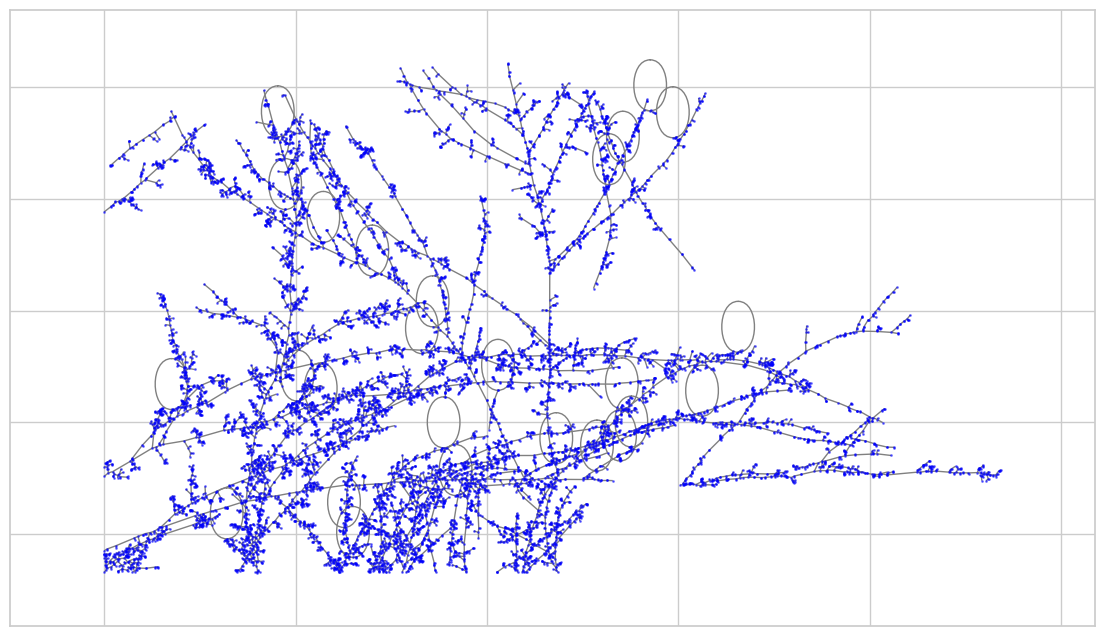

In [193]:
fig, ax = plt.subplots(figsize=(14, 8)) 

nx.draw_networkx_edges(G, pos=pts, width=1, alpha=1, edge_color="grey") 
nx.draw_networkx_nodes(G, pos=pts, node_size=1, alpha=0.5, node_color="blue")

In [194]:
G.remove_edges_from(nx.selfloop_edges(G))

## Garder la composante connectée géante

In [195]:
nx.is_connected(G)

False

In [196]:
# graphe une seule composante connectée
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
Gsub = G.subgraph(Gcc[0])

## Simplifier le graphe

In [197]:
G_simplified = simple_graph(Gsub)

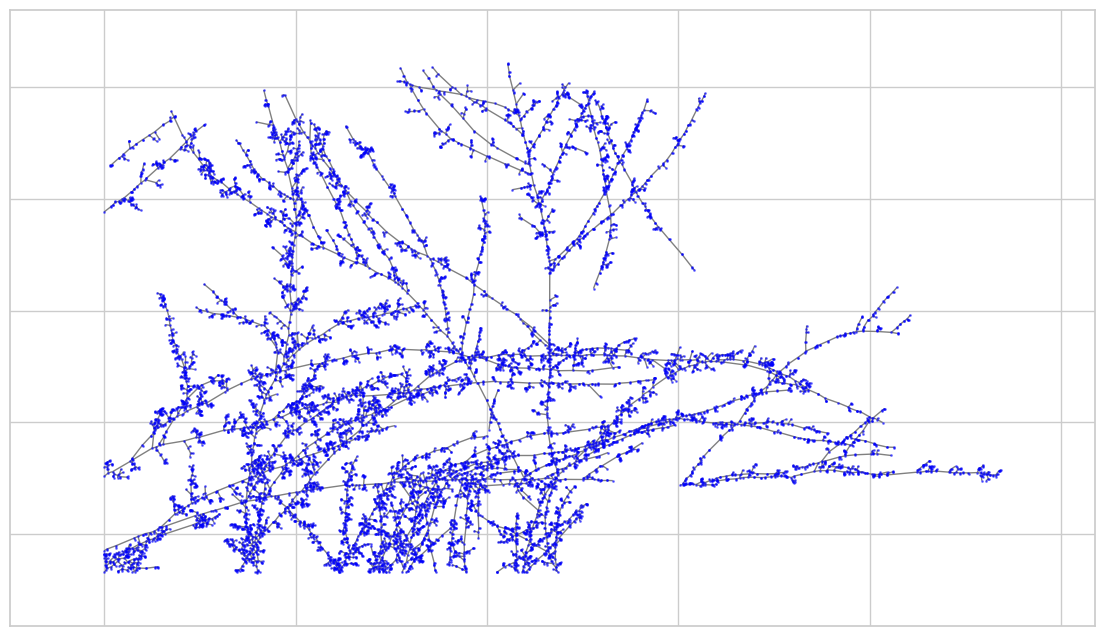

In [198]:
fig, ax = plt.subplots(figsize=(14, 8)) 

nx.draw_networkx_edges(G, pos=pts, width=1, alpha=1, edge_color="grey") 
nx.draw_networkx_nodes(G, pos=pts, node_size=1, alpha=0.5, node_color="blue")

## Formatting des noeuds

In [199]:
for n in G_simplified.nodes:
    if 'pts' not in G_simplified.nodes[n] and 'pts' in Gsub.nodes[n]:
        G_simplified.nodes[n]['pts'] = Gsub.nodes[n]['pts']

In [200]:
for n in G_simplified.nodes:
    pts = np.array(G_simplified.nodes[n]["pts"])
    if pts.ndim == 2 and pts.shape[1] == 2:
        pts = np.mean(pts, axis=0)
    elif pts.ndim != 1 or pts.shape[0] != 2:
        raise ValueError(f"Node {n} has unsupported shape {pts.shape}")
    G_simplified.nodes[n]["pts"] = tuple(pts)

# Nettoyer le graphe

In [201]:
G_clean = G.copy()

In [202]:
to_remove = [(u, v) for u, v, d in G_clean.edges(data=True) 
             if d.get('weight', 0) < 25 and (G_clean.degree[u] == 1 or G_clean.degree[v] == 1)]
G_clean.remove_edges_from(to_remove)

## Preprocessing

In [203]:
G_clean_cc = sorted(nx.connected_components(G_clean), key=len, reverse=True)
G_clean_sub = G_clean.subgraph(G_clean_cc[0])
G_clean_simple = simple_graph(G_clean_sub)

In [204]:
for n in G_clean_simple.nodes:
    if 'pts' not in G_clean_simple.nodes[n] and 'pts' in G_clean_sub.nodes[n]:
        G_clean_simple.nodes[n]['pts'] = G_clean_sub.nodes[n]['pts']

In [205]:
for n in G_clean_simple.nodes:
    pts = np.array(G_clean_simple.nodes[n]["pts"])
    if pts.ndim == 2 and pts.shape[1] == 2:
        pts = np.mean(pts, axis=0)
    elif pts.ndim != 1 or pts.shape[0] != 2:
        raise ValueError(f"Node {n} has unsupported shape {pts.shape}")
    G_clean_simple.nodes[n]["pts"] = tuple(pts)

## Visualisation (Napari)

In [206]:
points_G = np.array([G_simplified.nodes[n]['pts'] for n in G_simplified.nodes])

edges_G = []
for u, v in G_simplified.edges():
    pt_u = G_simplified.nodes[u]['pts']
    pt_v = G_simplified.nodes[v]['pts']
    edges_G.append([pt_u, pt_v])
edges_G = np.array(edges_G)

In [207]:
points_clean = np.array([G_clean_simple.nodes[n]['pts'] for n in G_clean_simple.nodes])

edges_clean = []
for u, v in G_clean_simple.edges():
    pt_u = G_clean_simple.nodes[u]['pts']
    pt_v = G_clean_simple.nodes[v]['pts']
    edges_clean.append([pt_u, pt_v])
edges_clean = np.array(edges_clean)

In [208]:
viewer = napari.Viewer()

viewer.add_image(img, name = "raw image")

viewer.add_points(points_G, name="nodes", size=10, face_color="blue", border_color="gray")
viewer.add_shapes(edges_G, shape_type="line", edge_color="white", edge_width=1, name="edges")

viewer.add_points(points_clean, name="nodes", size=10, face_color="yellow", border_color="gray")
viewer.add_shapes(edges_clean, shape_type="line", edge_color="lime", edge_width=1, name="edges")

napari.run()

# Mesures de base

In [3]:
G = pickle.load(open('../data/rhizophagus/12/4/R12_23_06_P10.pklclean', 'rb'))

In [4]:
pts = {n : G.nodes[n]["pts"] for n in G.nodes }
pts = {n : (y, -x) for n, (x, y) in pts.items()} 

## Nombre de nodes

In [15]:
nodes = G.number_of_nodes()
nodes

4116

## Nombre de edges

In [16]:
edges = G.number_of_edges()
edges

5024

## Distribution des degrés

In [17]:
degrees = G.fct_degrees()

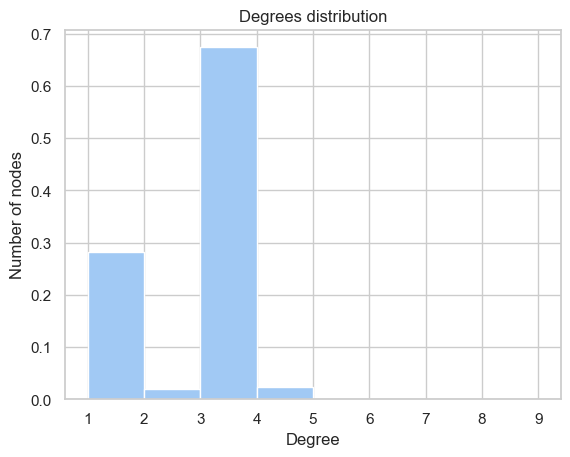

In [19]:
bins = np.arange(1, 10, 1)

plt.hist(degrees, bins=bins, density=True) #density pour mettre en probabilités
plt.title("Degrees distribution")

plt.xlabel("Degree")
plt.ylabel("Number of nodes")

plt.show()

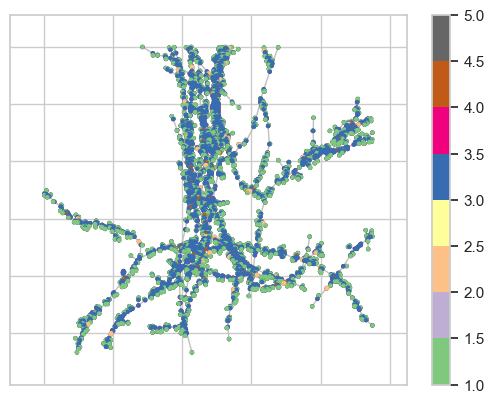

In [30]:
params = {"node_size" : 5,
          "with_labels" : False,
          "edge_color" : "silver"
         }
degrees = G.degree()
nodes = G.nodes()
n_color = np.asarray([degrees[n] for n in nodes])

nx.draw_networkx(G, pos=pts, **params, node_color=n_color, label=degrees) 

collection = nx.draw_networkx_nodes(G, pos=pts, node_color=n_color, label=degrees, node_size=5, cmap='Accent') 
plt.colorbar(collection) 

## Densité des cycles

In [31]:
c_density = cycle_density(G)
c_density

0.22084548104956267

## Longueur totale d'hyphes

In [32]:
hyphal_length = total_hyphal_length(G)
hyphal_length

205831.0550801066

## Densité spatiale

In [33]:
s_density = spatial_density(G)
s_density

0.004780829115899233

## Longueur des liens

In [ ]:
edges_l = edges_lengths(G)

In [ ]:
sns.histplot(edges_l)

# Autres mesures

## Coefficient de clustering

In [ ]:
clustering_c = nx.clustering(G)
clustering_c

In [ ]:
average_clustering = nx.average_clustering(G)
average_clustering

## Betweenness centrality

In [ ]:
bc = nx.betweenness_centrality(G) # 139 secondes
bc

## Diamètre

In [ ]:
diameter = nx.diameter(G) # résultat en edges
diameter

In [ ]:
diameter_dist = nx.diameter(G, weight="weight") # résultat en distance réelle, 131 secondes
diameter_dist

## Minimum spanning tree

In [ ]:
mst = nx.minimum_spanning_tree(G)

In [ ]:
fig, ax = plt.subplots(figsize = (5,5)) 

nx.draw_networkx_edges(mst, pos=pos, width=1, alpha=1) 
nx.draw_networkx_nodes(mst, pos=pos, node_size=1, alpha=0.5)

# Mesures d'efficience et de robustesse

## Global efficiency weighted

In [42]:
g_eff, average_length = global_efficiency_weighted(G)

In [43]:
g_eff

0.710112821161879

In [44]:
average_length

3905.6952267334555

## Local efficiency weighted

In [57]:
local_efficiency_weighted(G)

0.1263428456368645

## Robustness

In [6]:
ans = robustness_curve(G)
ans

(array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 array([1.00000000e+00, 3.64096339e-01, 1.82204196e-01, 3.87651624e-02,
        5.36352506e-03, 1.76350249e-03, 2.38112870e-03, 2.42868262e-03,
        1.76619358e-03, 9.18390040e-04, 1.62481369e-03, 1.91610597e-04,
        4.36513401e-04, 1.71993439e-04, 1.06900992e-03, 1.71993439e-04,
        3.43986878e-04, 1.71993439e-04, 0.00000000e+00, 0.00000000e+00]))

In [60]:
robustness_score(ans[0], ans[1])

0.07525267197525236

In [ ]:
fractions_removed, fractions_connected = robustness_curve(G)

In [13]:
sns.set_theme(style="whitegrid", context="paper", palette="muted")

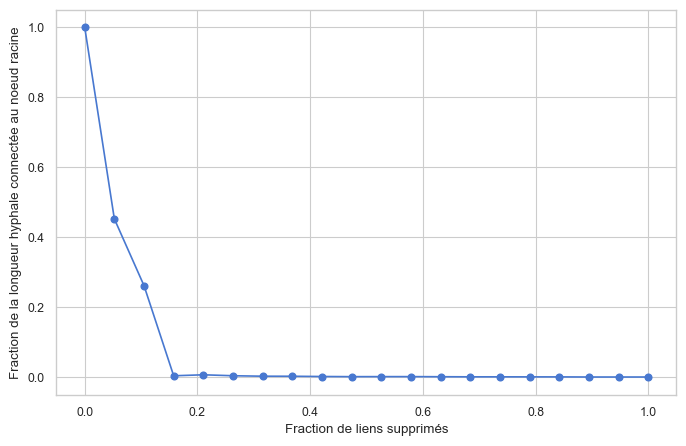

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(fractions_removed, fractions_connected, marker='o', linestyle='-')
plt.xlabel("Fraction de liens supprimés")
plt.ylabel("Fraction de la longueur hyphale connectée au noeud racine")

plt.grid(True)

plt.savefig("robustness_curve", dpi=250, bbox_inches="tight", pad_inches=0.1)

# Boucles sur l'ensemble des données

## Simplification des graphes et métriques de base

In [11]:
metrics_functions = {
    'nodes' : nx.number_of_nodes,
    'edges' : nx.number_of_edges,
    'degrees' : fct_degrees,
    'cycle density' : cycle_density,
    'total hyphal length' : total_hyphal_length,
    'spatial density' : spatial_density, 
    'num cycles' : num_cycles
}

### Preprocessing 

In [19]:
network_path = []

for sp in os.listdir("../data"):
    if not os.path.isdir(os.path.join("../data", sp)):
        continue
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith("pkl") :
                    path = os.path.join("../data", sp, boite, mesure, photo)
                    network_path.append(path)

In [20]:
for path in tqdm(network_path) :
    save_dir = os.path.dirname(path)
    graph_name = os.path.splitext(os.path.basename(path))[0]
    graph_path = os.path.join(save_dir, f"{graph_name}.pklclean" )

    if os.path.exists(graph_path) :
        continue
    
    G = pickle.load(open(path, 'rb'))
    G.remove_edges_from(nx.selfloop_edges(G))
    to_remove = [(u, v) for u, v, d in G.edges(data=True) if d.get('weight', 0) < 25 and (G.degree[u] == 1 or G.degree[v] == 1)]
    G.remove_edges_from(to_remove)
    G_cc = sorted(nx.connected_components(G), key = len, reverse = True)
    G_sub = G.subgraph(G_cc[0])
    G_simple = simple_graph(G_sub)
    for n in G_simple.nodes:
        if 'pts' not in G_simple.nodes[n] and 'pts' in G_sub.nodes[n]:
            G_simple.nodes[n]['pts'] = G_sub.nodes[n]['pts']

    for n in G_simple.nodes:
        pts = np.array(G_simple.nodes[n]["pts"])
        if pts.ndim == 2 and pts.shape[1] == 2:
            pts = np.mean(pts, axis=0)
        elif pts.ndim != 1 or pts.shape[0] != 2:
            raise ValueError(f"Node {n} has unsupported shape {pts.shape}")
        G_simple.nodes[n]["pts"] = tuple(pts)
    
    with open(graph_path, "wb") as f :
        pickle.dump(G_simple, f)

100%|████████████████████████████████████████████████████████████████████████████████| 611/611 [00:28<00:00, 21.54it/s]


### Mesures de base

In [12]:
results = []

for sp in os.listdir("../data"):
    if not os.path.isdir(os.path.join("../data", sp)):
        continue
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith(".pklclean") :
                    path = os.path.join("../data", sp, boite, mesure, photo)
                    G = pickle.load(open(path, 'rb'))

                    result = {
                        "sp" : sp,
                        "boite": boite,
                        "mesure" : mesure,
                        "photo": photo
                    }

                    for metric_name, func in metrics_functions.items():
                        result[metric_name] = func(G)
 
                    results.append(result)

C:\Users\Renée\AppData\Local\Temp\ipykernel_9080\2988335479.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  spatial_density = hyphal_length/area


### Sauvegarde des données

In [13]:
data = pd.DataFrame(results)

In [14]:
data

,sp,boite,mesure,photo,nodes,edges,degrees,cycle density,total hyphal length,spatial density,num cycles
0,gigaspora,34,1,G09_10_06_P01.pklclean,188,199,"[1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, ...",0.063830,27172.814230,0.003141,12
1,gigaspora,34,1,G09_10_06_P02.pklclean,24,27,"[1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, ...",0.166667,5174.771905,0.003525,4
2,gigaspora,34,1,G09_10_06_P03.pklclean,271,295,"[1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1, 2, 3, 3, ...",0.092251,31300.956237,0.003937,25
3,gigaspora,34,2,G09_16_06_P01.pklclean,27,36,"[1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",0.370370,2503.156934,0.095901,10
4,gigaspora,34,2,G09_16_06_P02.pklclean,47,53,"[1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, ...",0.148936,14402.975418,0.003400,7
...,...,...,...,...,...,...,...,...,...,...,...
606,rhizophagus,25,4,R25_14_07_P19.pklclean,2052,2420,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 3, 3, 1, 1, ...",0.179825,131443.376557,0.003692,369
607,rhizophagus,25,4,R25_14_07_P20.pklclean,1691,1962,"[1, 1, 1, 1, 1, 1, 3, 2, 1, 3, 1, 3, 1, 2, 3, ...",0.160852,125972.189220,0.004859,272
608,rhizophagus,25,4,R25_14_07_P21.pklclean,423,496,"[1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, ...",0.174941,29921.226293,0.004262,74
609,rhizophagus,25,4,R25_14_07_P22.pklclean,383,458,"[1, 1, 1, 2, 2, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, ...",0.198433,21063.123207,0.005682,76


In [15]:
data.to_csv('raw_data.csv', index=False)

### Résumé des données

In [26]:
summary = data.groupby(['mesure', 'boite']).agg(
    nodes_min = ('nodes', 'min'),
    nodes_max = ('nodes', 'max'),
    edges_min = ('edges', 'min'),
    edges_max = ('edges', 'max')
).reset_index()

summary

,mesure,boite,nodes_min,nodes_max,edges_min,edges_max
0,1,01,30,93,34,109
1,1,02,38,2089,39,2413
2,1,03,60,60,68,68
3,1,04,330,1686,379,2016
4,1,05,309,1654,339,1993
5,1,06,79,90,86,100
6,1,08,205,374,222,426
7,1,09,681,681,786,786
8,1,12,6,12,5,11
9,1,25,80,1083,89,1305


In [27]:
summary.to_excel('data_summary.xlsx', index=False)

## Longueur des liens

In [18]:
results_el = []

for sp in os.listdir("../data"):
    if not os.path.isdir(os.path.join("../data", sp)):
        continue
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith(".pklclean") :
                    path = os.path.join("../data", sp, boite, mesure, photo)
                    G = pickle.load(open(path, 'rb'))

                    result = {
                        "sp" : sp,
                        "boite": boite,
                        "mesure" : mesure,
                        "photo": photo
                    }

                    result["edge length"] = edges_lengths(G)
 
                    results_el.append(result)

### Sauvegarde des données

In [19]:
df_el = pd.DataFrame(results_el)

In [20]:
df_el

,sp,boite,mesure,photo,edge length
0,gigaspora,34,1,G09_10_06_P01.pklclean,"{(1, 14): 76.46713164636319, (3, 55): 478.0267..."
1,gigaspora,34,1,G09_10_06_P02.pklclean,"{(0, 3): 355.1340904816406, (3, 7): 41.4481771..."
2,gigaspora,34,1,G09_10_06_P03.pklclean,"{(0, 24): 96.25487000666512, (1, 38): 124.9873..."
3,gigaspora,34,2,G09_16_06_P01.pklclean,"{(2, 4): 36.124783736376884, (3, 5): 57.348835..."
4,gigaspora,34,2,G09_16_06_P02.pklclean,"{(23, 24): 237.18149695960687, (24, 43): 998.2..."
...,...,...,...,...,...
606,rhizophagus,25,4,R25_14_07_P19.pklclean,"{(1, 54): 56.568542494923804, (2, 21): 22.3730..."
607,rhizophagus,25,4,R25_14_07_P20.pklclean,"{(0, 108): 180.21254812026825, (2, 30): 55.772..."
608,rhizophagus,25,4,R25_14_07_P21.pklclean,"{(0, 14): 64.13267497929586, (2, 32): 128.2831..."
609,rhizophagus,25,4,R25_14_07_P22.pklclean,"{(501, 544): 292.4790590794493, (504, 520): 74..."


In [21]:
df_el.to_csv('raw_data_el.csv', index=False)

## Mesures d'efficience et de robustesse

In [14]:
er_functions = {
    'global efficiency weighted' : global_efficiency_weighted,
    'local efficiency weighted' : local_efficiency_weighted,
    'robustness curve' : robustness_curve
}

In [18]:
csv_path = "../results/csv/raw_data_er.csv"  # chemin vers le csv raw
recompute_on_modified = False

In [19]:
if os.path.exists(csv_path):
    df_existing = pd.read_csv(csv_path)
    already_done = set(zip(df_existing['sp'], df_existing['boite'], df_existing['mesure'], df_existing['photo']))
else:
    df_existing = pd.DataFrame()
    already_done = set()

In [20]:
df_existing

,sp,boite,mesure,photo,global efficiency weighted,local efficiency weighted,robustness curve
0,gigaspora,34,1,G09_10_06_P01.pklclean,"(0.7049258565728517, 2518.9715152961385)",0.085291,"(array([0. , 0.05263158, 0.10526316, 0...."
1,gigaspora,34,1,G09_10_06_P02.pklclean,"(0.8580666377271404, 1179.3760816092395)",0.111427,"(array([0. , 0.05263158, 0.10526316, 0...."
2,gigaspora,34,1,G09_10_06_P03.pklclean,"(0.6605827662753296, 2197.8538000943936)",0.074682,"(array([0. , 0.05263158, 0.10526316, 0...."
3,gigaspora,34,2,G09_16_06_P01.pklclean,"(0.907062896121047, 573.7517985891857)",0.482632,"(array([0. , 0.05263158, 0.10526316, 0...."
4,gigaspora,34,2,G09_16_06_P02.pklclean,"(0.8148118210877513, 1644.7154825806874)",0.139679,"(array([0. , 0.05263158, 0.10526316, 0...."
...,...,...,...,...,...,...,...
608,rhizophagus,25,4,R25_14_07_P19.pklclean,"(0.6901254225254861, 4425.907413165733)",0.099645,"(array([0. , 0.05263158, 0.10526316, 0...."
609,rhizophagus,25,4,R25_14_07_P20.pklclean,"(0.7174738364388545, 3073.8856094712164)",0.121267,"(array([0. , 0.05263158, 0.10526316, 0...."
610,rhizophagus,25,4,R25_14_07_P21.pklclean,"(0.7365926897971801, 2098.0936756012843)",0.121367,"(array([0. , 0.05263158, 0.10526316, 0...."
611,rhizophagus,25,4,R25_14_07_P22.pklclean,"(0.7337783615233417, 1598.604421081406)",0.124113,"(array([0. , 0.05263158, 0.10526316, 0...."


In [39]:
all_files = []
for sp in os.listdir("../data"):
    if not os.path.isdir(os.path.join("../data", sp)):
        continue
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith(".pklclean"):
                    path = os.path.join("../data", sp, boite, mesure, photo)
                    key = (sp, int(boite), int(mesure), photo)
                    if key in already_done: # retirer les fichiers déjà présents dans le csv de résultats
                        continue  
                    all_files.append((sp, boite, mesure, photo, path))

In [40]:
all_files

[('gigaspora',
  '34',
  '6',
  'G09_14_07_P01.pklclean',
  '../data\\gigaspora\\34\\6\\G09_14_07_P01.pklclean'),
 ('gigaspora',
  '34',
  '6',
  'G09_14_07_P02.pklclean',
  '../data\\gigaspora\\34\\6\\G09_14_07_P02.pklclean'),
 ('gigaspora',
  '34',
  '6',
  'G09_14_07_P03.pklclean',
  '../data\\gigaspora\\34\\6\\G09_14_07_P03.pklclean'),
 ('gigaspora',
  '34',
  '6',
  'G09_14_07_P04.pklclean',
  '../data\\gigaspora\\34\\6\\G09_14_07_P04.pklclean'),
 ('gigaspora',
  '34',
  '6',
  'G09_14_07_P05.pklclean',
  '../data\\gigaspora\\34\\6\\G09_14_07_P05.pklclean'),
 ('gigaspora',
  '34',
  '6',
  'G09_14_07_P06.pklclean',
  '../data\\gigaspora\\34\\6\\G09_14_07_P06.pklclean'),
 ('gigaspora',
  '34',
  '6',
  'G09_14_07_P07.pklclean',
  '../data\\gigaspora\\34\\6\\G09_14_07_P07.pklclean'),
 ('gigaspora',
  '34',
  '6',
  'G09_14_07_P08.pklclean',
  '../data\\gigaspora\\34\\6\\G09_14_07_P08.pklclean'),
 ('gigaspora',
  '34',
  '6',
  'G09_14_07_P09.pklclean',
  '../data\\gigaspora\\34\\6\\

In [42]:
results_er = []

for sp, boite, mesure, photo, path in tqdm(all_files):
    G = pickle.load(open(path, 'rb'))

    result = {
        "sp": sp,
        "boite": boite,
        "mesure": mesure,
        "photo": photo
    }

    for metric_name, func in er_functions.items():
        result[metric_name] = func(G)

    results_er.append(result)

 32%|█████████████████████████                                                      | 69/217 [25:36<1:31:00, 36.89s/it]

too large: Graph with 5989 nodes and 7208 edges


 32%|█████████████████████████▍                                                     | 70/217 [26:05<1:24:41, 34.57s/it]

too large: Graph with 7735 nodes and 9548 edges


 33%|█████████████████████████▊                                                     | 71/217 [26:46<1:29:04, 36.61s/it]

too large: Graph with 5105 nodes and 6230 edges


 34%|██████████████████████████▌                                                    | 73/217 [31:03<3:42:20, 92.64s/it]

too large: Graph with 8018 nodes and 9836 edges


 34%|██████████████████████████▉                                                    | 74/217 [31:42<3:01:58, 76.35s/it]

too large: Graph with 7517 nodes and 9144 edges


 41%|█████████████████████████████████▏                                               | 89/217 [48:31<55:27, 26.00s/it]

too large: Graph with 5212 nodes and 6350 edges


 41%|█████████████████████████████████▌                                               | 90/217 [48:53<52:11, 24.66s/it]

too large: Graph with 7612 nodes and 9290 edges


 42%|█████████████████████████████████▉                                               | 91/217 [49:29<58:58, 28.08s/it]

too large: Graph with 6145 nodes and 7524 edges


 43%|█████████████████████████████████▍                                            | 93/217 [56:32<4:45:45, 138.27s/it]

too large: Graph with 7150 nodes and 8734 edges


 61%|███████████████████████████████████████████████▊                              | 133/217 [1:37:53<39:29, 28.21s/it]

too large: Graph with 5525 nodes and 6615 edges


100%|██████████████████████████████████████████████████████████████████████████████| 217/217 [2:29:01<00:00, 41.20s/it]


In [48]:
G = pickle.load(open("../data/rhizophagus/06/3/R06_30_06_P12.pklclean", "rb"))

efficience_globale = global_efficiency_weighted_tips(G)

In [50]:
efficience_globale

(0.6341634262352845, 1131.2890560361734)

In [28]:
sources = [n for n, d in G.degree() if d == 1]

In [31]:
len(sources)

1247

In [33]:
results = {}

for source in tqdm(sources):
    results[source] = nx.single_source_dijkstra_path_length(G, source, weight="weight")

100%|██████████████████████████████████████████████████████████████████████████████| 1247/1247 [00:40<00:00, 31.17it/s]


In [36]:
results[sources[0]] # longueur du lien entre noeud source 0 et noeud source x 

{2: 0,
 47: 259.43202747039317,
 24: 365.621414253667,
 167: 398.5087158814589,
 229: 452.47927862993606,
 244: 466.95798729455515,
 234: 483.95798729455515,
 288: 513.3427636054054,
 259: 514.1580453109126,
 82: 527.2544518508369,
 343: 556.7920350185016,
 471: 640.6620927035904,
 566: 692.4479371575746,
 485: 699.3834420553287,
 581: 706.9332185318132,
 605: 710.5124322598206,
 190: 767.1576631658102,
 150: 803.7140123519142,
 148: 812.950080329414,
 131: 816.7785074541601,
 378: 825.0318193743631,
 140: 836.0562059920026,
 146: 853.9673242721173,
 318: 866.7531687261014,
 932: 877.8602464991093,
 189: 904.0734499347059,
 125: 939.8308092475866,
 1074: 952.8887316402129,
 812: 954.3019930921668,
 215: 955.3577211821678,
 152: 963.3805857240711,
 1119: 968.302945202586,
 153: 983.7947992864442,
 724: 1000.243118589121,
 248: 1006.8135653048835,
 1060: 1007.9597994520784,
 176: 1012.4222162844137,
 1144: 1021.5095759285629,
 118: 1033.9435076197947,
 1193: 1044.5806437404283,
 105: 106

In [41]:
lengths = nx.all_pairs_dijkstra_path_length(G, weight="weight", backend="parallel")  # compute shortest paths


In [42]:
lengths

<generator object all_pairs_dijkstra_path_length at 0x0000016E31D82AC0>

In [46]:
lengths_2 = []

for source in sources:

    dict = nx.single_source_dijkstra_path_length(G, source, weight="weight")
    
    lengths_2.append((source, dict))

In [44]:
lengths_2.type()

AttributeError: 'dict' object has no attribute 'type'

In [52]:
all_files = []

for sp in os.listdir("../data"):
    if not os.path.isdir(os.path.join("../data", sp)):
        continue
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith("pklclean") :
                    path = os.path.join("../data", sp, boite, mesure, photo)
                    all_files.append(path)

In [53]:
# ajouter nouveau calcul efficience
results_tips = []

for path in tqdm(all_files):
    G = pickle.load(open(path, 'rb'))
    num_nodes = nx.number_of_nodes(G)
    
    if num_nodes < 5000:
        continue

    result = {
        "sp": sp,
        "boite": boite,
        "mesure": mesure,
        "photo": photo
    }

    result["global efficiency weighted"] = global_efficiency_weighted_tips(G)

    results_tips.append(result)


100%|██████████████████████████████████████████████████████████████████████████████| 611/611 [7:58:13<00:00, 46.96s/it]


In [54]:
df_tips = pd.DataFrame(results_tips)

In [55]:
df_tips

,sp,boite,mesure,photo,global efficiency weighted
0,rhizophagus,25,4,R25_14_07_P23.pklclean,"(0.6401839462526163, 1270.152519330857)"
1,rhizophagus,25,4,R25_14_07_P23.pklclean,"(0.6627049202083222, 1190.523746574893)"
2,rhizophagus,25,4,R25_14_07_P23.pklclean,"(0.6591331879048355, 829.2162836931437)"
3,rhizophagus,25,4,R25_14_07_P23.pklclean,"(0.6563129007422174, 1120.8061962457039)"
4,rhizophagus,25,4,R25_14_07_P23.pklclean,"(0.6492477906003614, 993.4587695559153)"
...,...,...,...,...,...
67,rhizophagus,25,4,R25_14_07_P23.pklclean,"(0.655742376105437, 1106.2986210796819)"
68,rhizophagus,25,4,R25_14_07_P23.pklclean,"(0.6663376883535658, 1328.5032197934183)"
69,rhizophagus,25,4,R25_14_07_P23.pklclean,"(0.7141726115481378, 907.7866080312969)"
70,rhizophagus,25,4,R25_14_07_P23.pklclean,"(0.6922975948943003, 1119.532571055401)"


In [56]:
df_tips.to_csv("raw_data_er_tips.csv", index=False)

In [3]:
names = []

for sp in os.listdir("../data"):
    if not os.path.isdir(os.path.join("../data", sp)):
        continue
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith("pklclean") :
                    path = os.path.join("../data", sp, boite, mesure, photo)
                    G = pickle.load(open(path, 'rb'))
                    num_nodes = nx.number_of_nodes(G)
    
                    if num_nodes < 5000:
                        continue

                    result = {
                        "sp": sp,
                        "boite": boite,
                        "mesure": mesure,
                        'photo' : photo}

                    names.append(result)

In [5]:
names = pd.DataFrame(names)

In [7]:
names.to_csv("names.csv", index=False)

### Sauvegarde des données

In [43]:
df_new = pd.DataFrame(results_er)
df_er = pd.concat([df_existing, df_new], ignore_index=True) # assembler les données nouvelles avec les anciennes

In [44]:
df_er

,sp,boite,mesure,photo,global efficiency weighted,local efficiency weighted,robustness curve
0,gigaspora,34,1,G09_10_06_P01.pklclean,"(0.7049258565728517, 2518.9715152961385)",0.085291,"(array([0. , 0.05263158, 0.10526316, 0...."
1,gigaspora,34,1,G09_10_06_P02.pklclean,"(0.8580666377271404, 1179.3760816092395)",0.111427,"(array([0. , 0.05263158, 0.10526316, 0...."
2,gigaspora,34,1,G09_10_06_P03.pklclean,"(0.6605827662753296, 2197.8538000943936)",0.074682,"(array([0. , 0.05263158, 0.10526316, 0...."
3,gigaspora,34,2,G09_16_06_P01.pklclean,"(0.907062896121047, 573.7517985891857)",0.482632,"(array([0. , 0.05263158, 0.10526316, 0...."
4,gigaspora,34,2,G09_16_06_P02.pklclean,"(0.8148118210877513, 1644.7154825806874)",0.139679,"(array([0. , 0.05263158, 0.10526316, 0...."
...,...,...,...,...,...,...,...
608,rhizophagus,25,4,R25_14_07_P19.pklclean,"(0.6901254225254861, 4425.907413165733)",0.099645,"([0.0, 0.05263157894736842, 0.1052631578947368..."
609,rhizophagus,25,4,R25_14_07_P20.pklclean,"(0.7174738364388545, 3073.8856094712164)",0.121267,"([0.0, 0.05263157894736842, 0.1052631578947368..."
610,rhizophagus,25,4,R25_14_07_P21.pklclean,"(0.7365926897971801, 2098.0936756012843)",0.121367,"([0.0, 0.05263157894736842, 0.1052631578947368..."
611,rhizophagus,25,4,R25_14_07_P22.pklclean,"(0.7337783615233417, 1598.604421081406)",0.124113,"([0.0, 0.05263157894736842, 0.1052631578947368..."


In [45]:
df_er.to_csv("raw_data_er.csv", index=False)

In [25]:
all_files = []
for sp in os.listdir("../data"):
    if not os.path.isdir(os.path.join("../data", sp)):
        continue
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith(".pklclean"):
                    path = os.path.join("../data", sp, boite, mesure, photo)

                    all_files.append(path)

In [26]:
all_files

['../data\\gigaspora\\34\\1\\G09_10_06_P01.pklclean',
 '../data\\gigaspora\\34\\1\\G09_10_06_P02.pklclean',
 '../data\\gigaspora\\34\\1\\G09_10_06_P03.pklclean',
 '../data\\gigaspora\\34\\2\\G09_16_06_P01.pklclean',
 '../data\\gigaspora\\34\\2\\G09_16_06_P02.pklclean',
 '../data\\gigaspora\\34\\2\\G09_16_06_P04.pklclean',
 '../data\\gigaspora\\34\\2\\G09_16_06_P05.pklclean',
 '../data\\gigaspora\\34\\2\\G09_16_06_P06.pklclean',
 '../data\\gigaspora\\34\\3\\G09_23_06_P01.pklclean',
 '../data\\gigaspora\\34\\3\\G09_23_06_P02.pklclean',
 '../data\\gigaspora\\34\\3\\G09_23_06_P03.pklclean',
 '../data\\gigaspora\\34\\3\\G09_23_06_P04.pklclean',
 '../data\\gigaspora\\34\\3\\G09_23_06_P05.pklclean',
 '../data\\gigaspora\\34\\3\\G09_23_06_P06.pklclean',
 '../data\\gigaspora\\34\\3\\G09_23_06_P07.pklclean',
 '../data\\gigaspora\\34\\3\\G09_23_06_P08.pklclean',
 '../data\\gigaspora\\34\\3\\G09_23_06_P09.pklclean',
 '../data\\gigaspora\\34\\3\\G09_23_06_P10.pklclean',
 '../data\\gigaspora\\34\\3\

## Betweenness centrality 

### Average betweenness centrality : noeuds

In [57]:
def average_betweenness_centrality(G):
    num_nodes = nx.number_of_nodes(G)
    if num_nodes > 5000:
        return np.nan
    bc = nx.betweenness_centrality(G, weight="weight")
    sum_bc = sum(bc.values())
    abc = sum_bc / num_nodes
    return abc

In [59]:
from collections import defaultdict

def betweenness_centrality_tips(G, weight="weight"):
    tips = [n for n, d in G.degree() if d == 1]
    if not tips:
        return dict.fromkeys(G, 0.0)
    
    bc = defaultdict(float)
    
    for source in tips:
        lengths, paths = nx.single_source_dijkstra(G, source, weight=weight)
        for target, path in paths.items():
            if target == source:
                continue
          
            for node in path[1:-1]:
                bc[node] += 1.0
    
  
    n = len(G)
    if n > 2:
        scale = 1 / ((n-1)*(n-2))
        for node in bc:
            bc[node] *= scale
    return dict(bc)


In [60]:
def average_betweenness_centrality_tips(G):
    num_nodes = nx.number_of_nodes(G)
    if num_nodes < 5000:
        return np.nan
    bc = betweenness_centrality_tips(G, weight="weight")
    sum_bc = sum(bc.values())
    abc = sum_bc / num_nodes
    return abc

### Average betweenness centrality : liens

In [58]:
def average_edge_betweenness_centrality(G): 
    num_edges = nx.number_of_edges(G)
    num_nodes = nx.number_of_nodes(G)
    if num_nodes > 5000:
        return np.nan
    ebc = nx.edge_betweenness_centrality(G, weight = "weight")
    sum_ebc = sum(ebc.values())
    aebc = sum_ebc / num_edges
    return aebc

In [61]:
def edge_betweenness_centrality_tips(G, weight="weight"):
    tips = [n for n, d in G.degree() if d == 1]
    if not tips:
        return dict.fromkeys(G.edges, 0.0)
    
    ebc = defaultdict(float)
    
    for source in tips:
        lengths, paths = nx.single_source_dijkstra(G, source, weight=weight)
        for target, path in paths.items():
            if target == source:
                continue
          
            for u, v in zip(path[:-1], path[1:]):
                ebc[(u,v)] += 1.0
    
    
    n = len(G)
    if n > 2:
        scale = 1 / ((n-1)*(n-2))
        for edge in ebc:
            ebc[edge] *= scale
    return dict(ebc)


In [62]:
def average_edge_betweenness_centrality_tips(G): 
    num_edges = nx.number_of_edges(G)
    num_nodes = nx.number_of_nodes(G)
    if num_nodes < 5000:
        return np.nan
    ebc = edge_betweenness_centrality_tips(G, weight = "weight")
    sum_ebc = sum(ebc.values())
    aebc = sum_ebc / num_edges
    return aebc

In [59]:
csv_path = "../results/csv/df_bc.csv"  # chemin vers le csv raw
recompute_on_modified = False

In [60]:
if os.path.exists(csv_path):
    df_existing = pd.read_csv(csv_path)
    already_done = set(zip(df_existing['sp'], df_existing['boite'], df_existing['mesure'], df_existing['photo']))
else:
    df_existing = pd.DataFrame()
    already_done = set()

In [61]:
all_files = []
for sp in os.listdir("../data"):
    if not os.path.isdir(os.path.join("../data", sp)):
        continue
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith(".pklclean"):
                    path = os.path.join("../data", sp, boite, mesure, photo)
                    key = (sp, int(boite), int(mesure), photo)
                    if key in already_done: # retirer les fichiers déjà présents dans le csv de résultats
                        continue  
                    all_files.append((sp, boite, mesure, photo, path))

In [62]:
all_files

[('gigaspora',
  '34',
  '3',
  'G09_23_06_P01.pklclean',
  '../data\\gigaspora\\34\\3\\G09_23_06_P01.pklclean'),
 ('gigaspora',
  '34',
  '3',
  'G09_23_06_P02.pklclean',
  '../data\\gigaspora\\34\\3\\G09_23_06_P02.pklclean'),
 ('gigaspora',
  '34',
  '3',
  'G09_23_06_P03.pklclean',
  '../data\\gigaspora\\34\\3\\G09_23_06_P03.pklclean'),
 ('gigaspora',
  '34',
  '3',
  'G09_23_06_P04.pklclean',
  '../data\\gigaspora\\34\\3\\G09_23_06_P04.pklclean'),
 ('gigaspora',
  '34',
  '3',
  'G09_23_06_P05.pklclean',
  '../data\\gigaspora\\34\\3\\G09_23_06_P05.pklclean'),
 ('gigaspora',
  '34',
  '3',
  'G09_23_06_P06.pklclean',
  '../data\\gigaspora\\34\\3\\G09_23_06_P06.pklclean'),
 ('gigaspora',
  '34',
  '3',
  'G09_23_06_P07.pklclean',
  '../data\\gigaspora\\34\\3\\G09_23_06_P07.pklclean'),
 ('gigaspora',
  '34',
  '3',
  'G09_23_06_P08.pklclean',
  '../data\\gigaspora\\34\\3\\G09_23_06_P08.pklclean'),
 ('gigaspora',
  '34',
  '3',
  'G09_23_06_P09.pklclean',
  '../data\\gigaspora\\34\\3\\

In [63]:
results_bc = []

for sp, boite, mesure, photo, path in tqdm(all_files):
    G = pickle.load(open(path, 'rb'))
    
    result = {
        "sp": sp,
        "boite": boite,
        "mesure": mesure,
        "photo": photo
    }

    result["average bc nodes"] = average_betweenness_centrality(G)

    result["average bc edges"] = average_edge_betweenness_centrality(G)
    
    results_bc.append(result)

100%|██████████████████████████████████████████████████████████████████████████████| 472/472 [9:18:25<00:00, 70.99s/it]


In [55]:
all_files = []
for sp in os.listdir("../data"):
    if not os.path.isdir(os.path.join("../data", sp)):
        continue
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith(".pklclean"):
                    path = os.path.join("../data", sp, boite, mesure, photo)

                    all_files.append((sp, boite, mesure, photo, path))

In [63]:
results_bc_tips = []

for sp, boite, mesure, photo, path in tqdm(all_files):
    G = pickle.load(open(path, 'rb'))
    
    result = {
        "sp": sp,
        "boite": boite,
        "mesure": mesure,
        "photo": photo
    }

    result["average bc nodes"] = average_betweenness_centrality_tips(G)

    result["average bc edges"] = average_edge_betweenness_centrality_tips(G)
    
    results_bc_tips.append(result)

 88%|████████████████████████████████████████████████████████████████▉         | 536/611 [41:27:32<5:48:04, 278.46s/it]


KeyboardInterrupt: 

In [65]:
df_bc_tips = pd.DataFrame(results_bc_tips)

In [66]:
df_bc_tips

,sp,boite,mesure,photo,average bc nodes,average bc edges
0,gigaspora,34,1,G09_10_06_P01.pklclean,NaN,NaN
1,gigaspora,34,1,G09_10_06_P02.pklclean,NaN,NaN
2,gigaspora,34,1,G09_10_06_P03.pklclean,NaN,NaN
3,gigaspora,34,2,G09_16_06_P01.pklclean,NaN,NaN
4,gigaspora,34,2,G09_16_06_P02.pklclean,NaN,NaN
...,...,...,...,...,...,...
531,rhizophagus,12,4,R12_23_06_P10.pklclean,NaN,NaN
532,rhizophagus,12,4,R12_23_06_P11.pklclean,0.003822,0.003303
533,rhizophagus,12,4,R12_23_06_P12.pklclean,0.004050,0.003366
534,rhizophagus,12,4,R12_23_06_P13.pklclean,NaN,NaN


In [67]:
df_bc_tips.to_csv('raw_data_bc_tips.csv', index=False)

### Sauvegarde des données

In [66]:
df_new = pd.DataFrame(results_bc)
df_bc = pd.concat([df_existing, df_new], ignore_index=True)

In [67]:
df_bc

,sp,boite,mesure,photo,average bc nodes,average bc edges
0,gigaspora,34,1,G09_10_06_P01.pklclean,0.085529,0.084967
1,gigaspora,34,1,G09_10_06_P02.pklclean,0.182806,0.185990
2,gigaspora,34,1,G09_10_06_P03.pklclean,0.066095,0.063659
3,gigaspora,34,2,G09_16_06_P01.pklclean,0.216866,0.178379
4,gigaspora,34,2,G09_16_06_P02.pklclean,0.146531,0.143281
...,...,...,...,...,...,...
608,rhizophagus,25,4,R25_14_07_P19.pklclean,0.030610,0.026343
609,rhizophagus,25,4,R25_14_07_P20.pklclean,0.023566,0.020797
610,rhizophagus,25,4,R25_14_07_P21.pklclean,0.052161,0.046289
611,rhizophagus,25,4,R25_14_07_P22.pklclean,0.060855,0.052808


In [68]:
df_bc.to_csv('raw_data_bc.csv', index=False)

## Angles des branchements

In [69]:
results_angles = []

for sp in os.listdir("../data"):
    if not os.path.isdir(os.path.join("../data", sp)):
        continue
    for boite in os.listdir(os.path.join("../data", sp)):
        for mesure in os.listdir(os.path.join("../data", sp, boite)):
            for photo in os.listdir(os.path.join("../data", sp, boite, mesure)):
                if photo.endswith(".pklclean"):
                    path = os.path.join("../data", sp, boite, mesure, photo)
                    G = pickle.load(open(path, 'rb'))

                    pts = {n: G.nodes[n]["pts"] for n in G.nodes}
                    pts = {n: (y, -x) for n, (x, y) in pts.items()}

                    for u, v in G.edges():
                        if u in pts and v in pts:
                            x1, y1 = pts[u]
                            x2, y2 = pts[v]

                            angle = np.arctan2(y2 - y1, x2 - x1)

                            result = {
                                "sp": sp,
                                "boite": boite,
                                "mesure": mesure,
                                "photo": photo,
                                "angle": angle
                            }

                            results_angles.append(result)

### Sauvegarde des données

In [70]:
df_angles = pd.DataFrame(results_angles)

In [71]:
df_angles

,sp,boite,mesure,photo,angle
0,gigaspora,34,1,G09_10_06_P01.pklclean,-1.927016
1,gigaspora,34,1,G09_10_06_P01.pklclean,-1.927119
2,gigaspora,34,1,G09_10_06_P01.pklclean,-2.579566
3,gigaspora,34,1,G09_10_06_P01.pklclean,-2.246823
4,gigaspora,34,1,G09_10_06_P01.pklclean,-2.644877
...,...,...,...,...,...
1617767,rhizophagus,25,4,R25_14_07_P23.pklclean,-0.467311
1617768,rhizophagus,25,4,R25_14_07_P23.pklclean,-1.101196
1617769,rhizophagus,25,4,R25_14_07_P23.pklclean,-0.986818
1617770,rhizophagus,25,4,R25_14_07_P23.pklclean,-2.653259


In [72]:
df_angles.to_csv("raw_data_angles.csv", index=False)